# Introgression Trajectories
Using the sample x bin matrices, plot introgression trajectories over time. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from plotnine import *
import sys
sys.path.append("../src/")
from src import legend_kwargs

metadata = pd.read_csv("../processed-data/metadata_combined.csv.gz", index_col=0)
# I failed to remove flagged allentoft samples when saving the medatata, so this is necessary to get rid of those
# TODO: Rework the metadata script to remove flag samples
# TODO: Might also need to make sure that the metadata I save has the same sample names that I use in the samplebybins
metadata_allentoft = pd.read_csv("../processed-data/metadata_allentoft_et_al_2024.csv", index_col=0)
flag_samples = metadata_allentoft.loc[metadata_allentoft["Flag"] != "0"].index
metadata.drop(flag_samples, inplace=True)
metadata.head()

,Latitude,Longitude,Data source,Age average,Sex
Individual ID,,,,,
baa01,-29.54,31.22,Schlebusch_Science_2017,1909.0,male
bab01,-29.54,31.22,Schlebusch_Science_2017,2041.0,male
I9133,-31.98,18.52,Skoglund_Cell_2017,1970.0,male
I9134,-32.81,17.95,Skoglund_Cell_2017,1199.0,female
ela01,-28.92,29.13,Schlebusch_Science_2017,493.0,female


In [2]:
def initialize_multiplot(n_plots, n_cols=3, **kwargs):
    '''Given a certain number of plots, initialize subplots that have that many
    plots divided into n_cols columns. 
    '''    
    n_rows = n_plots // n_cols+1 if n_plots % n_cols != 0 else n_plots // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, **kwargs)
    # Remove any plots that won't be used
    lastrow = n_rows - 1
    first_unused = (n_plots ) % n_cols
    if first_unused != 0:
        for col in range(first_unused, n_cols):
            axs[lastrow, col].remove()
    return fig, axs, get_axes(n_plots, n_cols)

def get_axes(n_plots, n_cols):
    '''Generator to use with the above initialize_multiplots function that gets 
    the correct axis indices as you iterate your plotting function

    USAGE: 
    fig, axs, which_ax = initialize_multiplot(n_cols, n_plots)
    for ...:
        row, col = next(which_ax)
        plot_fxn(*args, ax=axs[row, col])
    '''
    idx = 0
    n_rows = n_plots//n_cols+1 if n_plots%n_cols!=0 else n_plots//n_cols
    while idx <= n_plots-1:
        row = idx // n_cols
        col = idx % n_cols
        yield row, col
        idx+=1

In [3]:
# metadata_leo = pd.read_csv("../processed-data/iasi_metadata.csv",)
# metadata_leo[["Sample Name in origina publication", "Sample name this study"]]
# [i for i in metadata_leo["Sample Name in origina publication"].unique() if "." in i]
# print(f"Samples not in index: {len([i for i in samplebybin.index if i not in metadata.index])}")
# print(f"Samples not in index: {len([i for i in samplebybin.index.str.replace('.', '-') if i not in metadata.index])}")

## Make a function to plot ancestry at loci by age bins
`TODO`: Probably would be better to make barplots

In [4]:
regions = pd.read_csv("../processed-data/racimo_adaptive_regions.txt", sep="\t")
chrom = 1

In [5]:
samplebybin = pd.read_csv(f"../processed-data/sample_by_bin/chr{chrom}.csv.gz", index_col=0)
# Need to manually rename modern samples :(
samplebybin.index = samplebybin.index.str.replace('.', '-')
print(f"Samples not in index: {len([i for i in samplebybin.index.str.replace('.', '-') if i not in metadata.index])}")
samplebybin.head()

Samples not in index: 0


,0.0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,...,283.41,283.415,283.42,283.425,283.43,283.435,283.44,283.445,283.45,283.455
UstIshim,0.000120,0.000104,0.000084,0.000059,0.000031,0.0,0.0,0.000001,0.0,0.000000,...,0.000244,0.000224,0.000199,0.000168,0.000132,0.000092,0.000046,0.000071,0.000172,0.000270
Kostenki,0.000272,0.000259,0.000225,0.000170,0.000094,0.0,0.0,0.000003,0.0,0.000000,...,0.000270,0.000295,0.000295,0.000270,0.000221,0.000148,0.000052,0.000109,0.000337,0.000547
SII,0.000302,0.000306,0.000278,0.000217,0.000124,0.0,0.0,0.000004,0.0,0.000000,...,0.000383,0.000419,0.000419,0.000382,0.000310,0.000202,0.000060,0.000122,0.000378,0.000605
SIII,0.000344,0.000349,0.000316,0.000246,0.000140,0.0,0.0,0.000005,0.0,0.000000,...,0.000422,0.000459,0.000458,0.000417,0.000339,0.000222,0.000067,0.000137,0.000424,0.000677
SIV,0.000359,0.000362,0.000328,0.000256,0.000147,0.0,0.0,0.000005,0.0,0.000001,...,0.000432,0.000472,0.000471,0.000430,0.000349,0.000230,0.000070,0.000144,0.000444,0.000708


In [6]:
bin_width = 2000
metadata["Bin"] = metadata["Age average"] // bin_width
unique_bins = sorted(metadata["Bin"].unique().tolist())[::-1]
bin_means, bin_n_samples = [], []
for b in unique_bins:
    bin_means.append(
        samplebybin.loc[
            metadata[metadata["Bin"] == b].index
        ].mean()
    )
    bin_n_samples.append(
        len(metadata[metadata["Bin"] == b].index)
    )
# Put results into df
binned = pd.DataFrame(bin_means)
binned.index = unique_bins

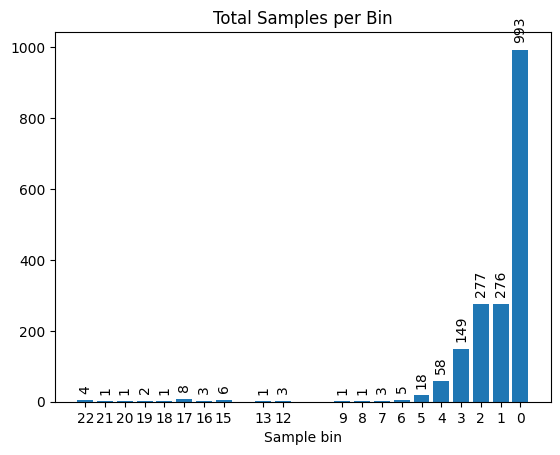

In [7]:
fig, ax = plt.subplots()
p = ax.bar(unique_bins, bin_n_samples)
ax.invert_xaxis()
ax.set_xticks(unique_bins)
ax.bar_label(p, rotation=90, padding=5)

ax.set_title("Total Samples per Bin")
ax.set_xlabel("Sample bin")

plt.show()

In [8]:
# # Given the start and end positions of an ROI, find the bins in the samplebybin containing that ROI
# import matplotlib.ticker as mtick

# for _, row in regions[regions["chrom"] == chrom].iterrows():
#     start, end = row['start'], row['stop']
#     get_bidx = lambda x: x / 1e6 // .05
#     binmin, binmax = get_bidx(start), get_bidx(end)
#     roi_bidx = np.arange(binmin, binmax + 1)

#     fig, ax = plt.subplots()
#     binned.iloc[:, roi_bidx].plot(style="o", markersize=1, ax=ax)
#     ax.invert_xaxis()
#     ax.set_ylabel("Mean Neanderthal Ancestry")
#     ax.set_xlabel("Age Bin")
#     ax.set_title(row["genes"] if not pd.isna(row['genes']) else row['plot label'])
#     ax.set_xticks(unique_bins)
#     ax.axvline(5.5, c='r', linestyle="--", alpha=.5)
#     # ax.set_yscale("log")
#     # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#     ax.legend(title="Bin", **legend_kwargs())
#     plt.show()

### Plot trajectories

In [45]:
def plot_rois(chrom):
    samplebybin = pd.read_csv(f"../processed-data/sample_by_bin/chr{chrom}.csv.gz", index_col=0)
    # Need to manually rename modern samples :(
    samplebybin.index = samplebybin.index.str.replace('.', '-')

    bin_width = 2000
    metadata["Bin"] = metadata["Age average"] // bin_width
    unique_bins = sorted(metadata["Bin"].unique().tolist())[::-1]
    bin_means, bin_n_samples = [], []
    for b in unique_bins:
        bin_means.append(
            samplebybin.loc[
                metadata[metadata["Bin"] == b].index
            ].mean()
        )
        bin_n_samples.append(
            len(metadata[metadata["Bin"] == b].index)
        )
    # Put results into df
    binned = pd.DataFrame(bin_means)
    binned.index = unique_bins
    # Now let's look at the ROIs within the specified chromosome
    regions_chrom = regions[regions["chrom"] == chrom]
    n_regions = len(regions_chrom)

    # # Initialize plots
    # fig, axs, which_ax = initialize_multiplot(n_regions)
    for _, row in regions[regions["chrom"] == chrom].iterrows():
        start, end = row['start'], row['stop']
        get_bidx = lambda x: x / 1e6 // .05
        binmin, binmax = get_bidx(start), get_bidx(end)
        roi_bidx = np.arange(binmin, binmax + 1)

        fig, ax = plt.subplots()
        binned.iloc[:, roi_bidx].plot(style="o", markersize=1, ax=ax)
        ax.axvline(5.5, c='r', linestyle="--", alpha=.5)
        ax.invert_xaxis()
        ax.set_ylabel("Mean Neanderthal Ancestry")
        ax.set_xlabel("Age Bin")
        ax.set_title(row["genes"] if not pd.isna(row['genes']) else row['plot label'])
        ax.set_xticks(unique_bins)
        # ax.set_yscale("log")
        # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.legend(title="Bin", **legend_kwargs())

    # for _, row in regions_chrom.iterrows():
    #     start, end = row['start'], row['stop']
    #     get_bidx = lambda x: x / 1e6 // .05
    #     binmin, binmax = get_bidx(start), get_bidx(end)
    #     roi_bidx = np.arange(binmin, binmax + 1)

    #     row, col = next(which_ax)
    #     binned.iloc[:, roi_bidx].plot(style="o", markersize=1, ax=axs[col])
    #     axs[row, col].invert_xaxis()
    #     axs[row, col].set_ylabel("Mean Neanderthal Ancestry")
    #     axs[row, col].set_xlabel("Age Bin")
    #     axs[row, col].set_title(row["genes"] if not pd.isna(row['genes']) else row['plot label'])
    #     axs[row, col].set_xticks(unique_bins)
    #     # axs[row, col].set_yscale("log")
    #     # axs[row, col].yaxis.set_major_formatter(mtick.PercentFormatter())
    #     axs[row, col].legend(title="Bin", **legend_kwargs())
        # return ax

        plt.show()



CHROMOSOME 1


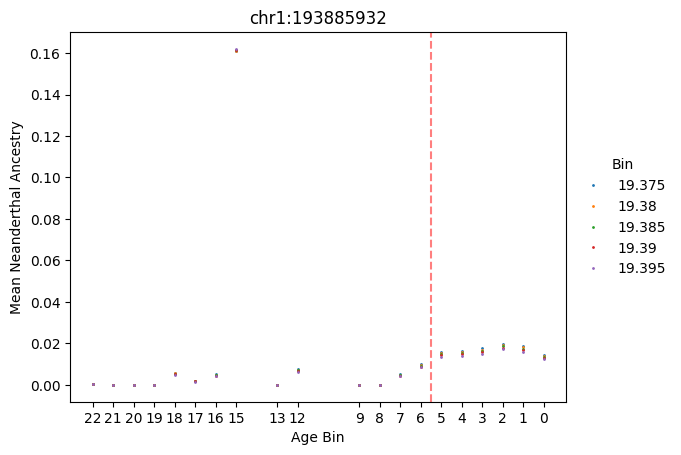

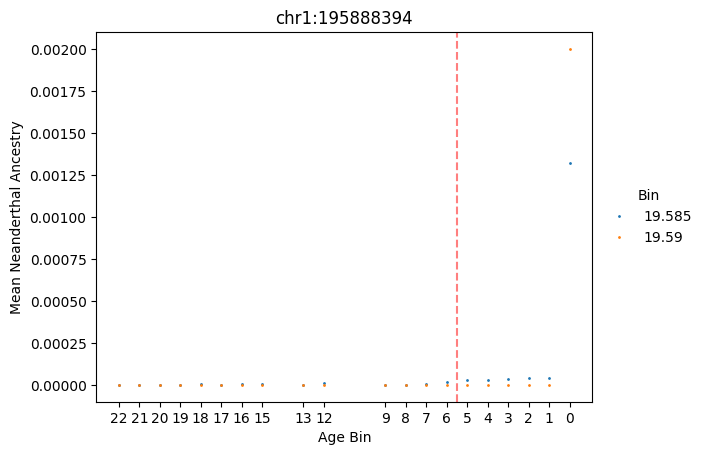

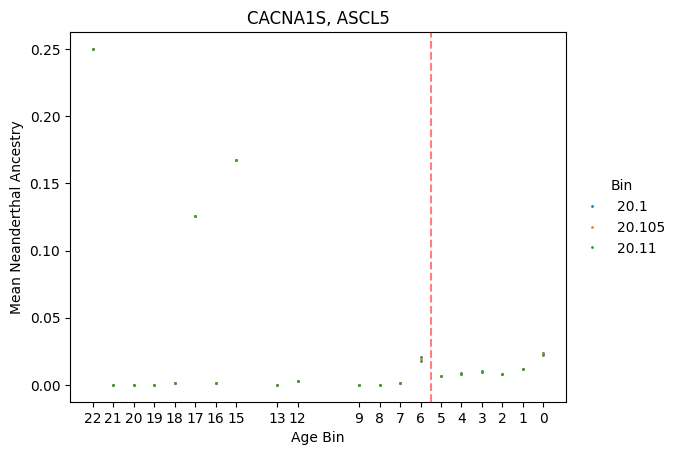

CHROMOSOME 2


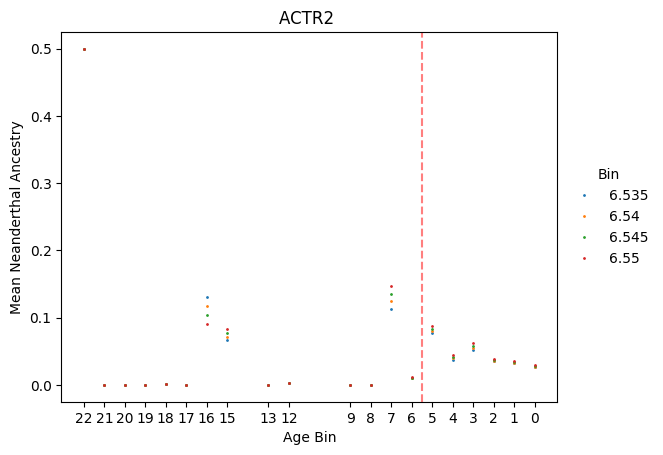

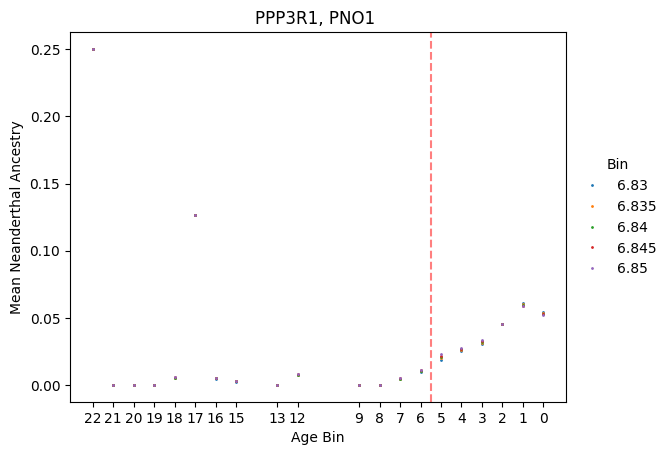

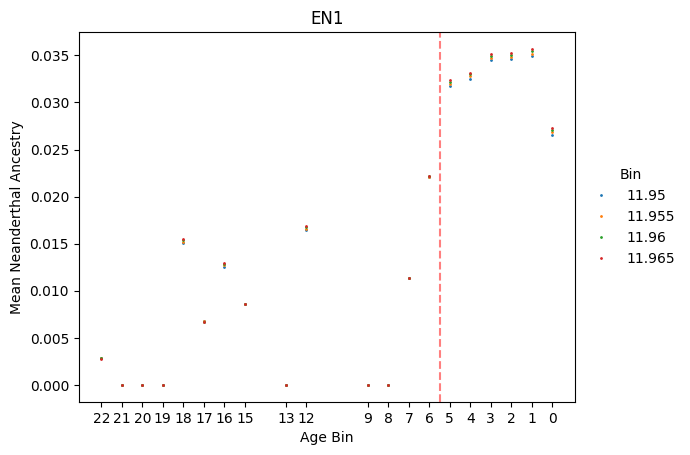

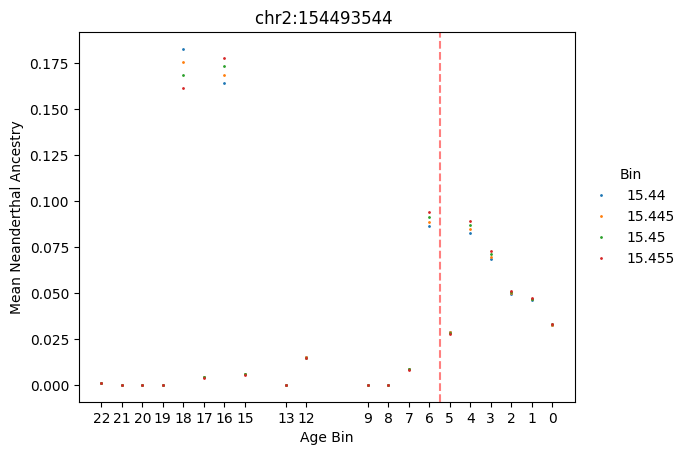

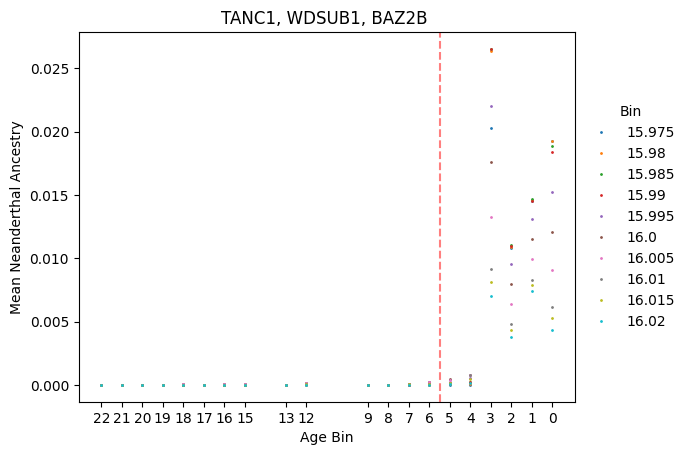

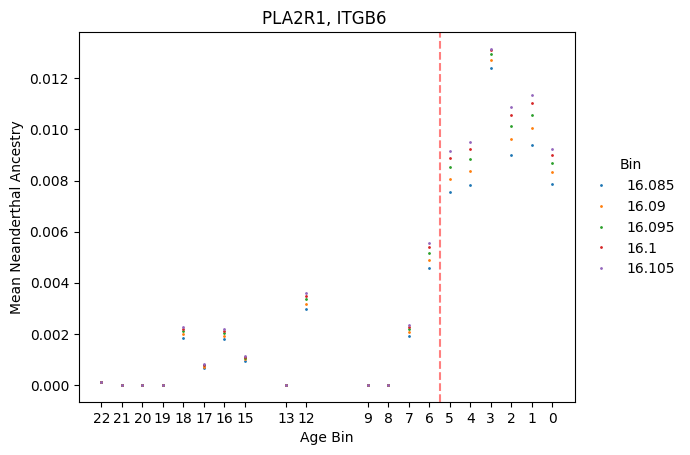

CHROMOSOME 4


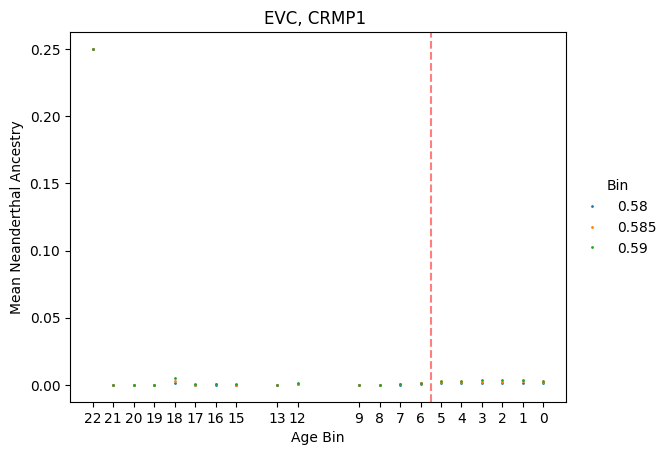

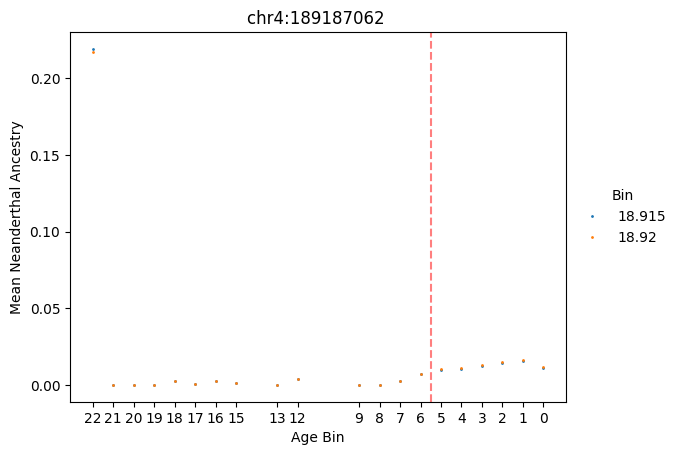

CHROMOSOME 5


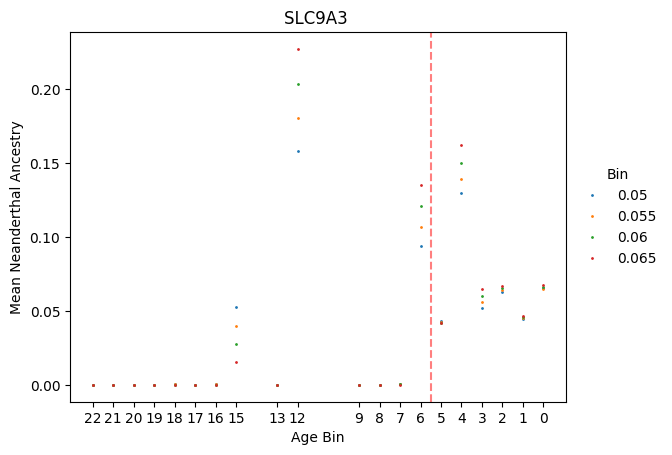

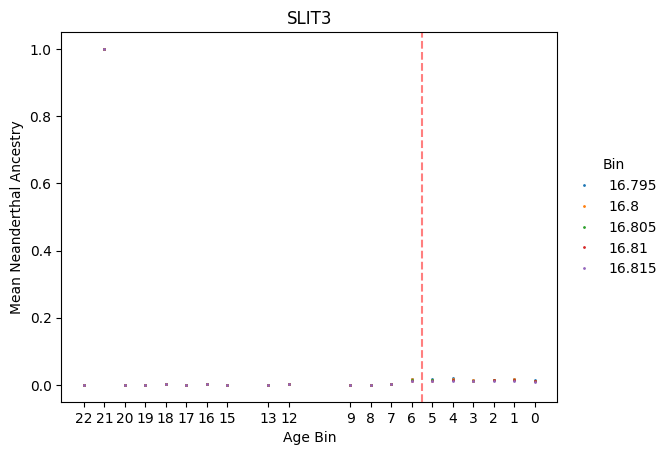

CHROMOSOME 6


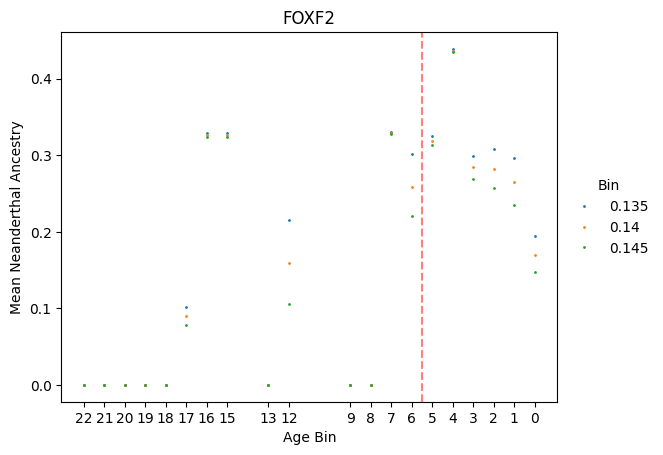

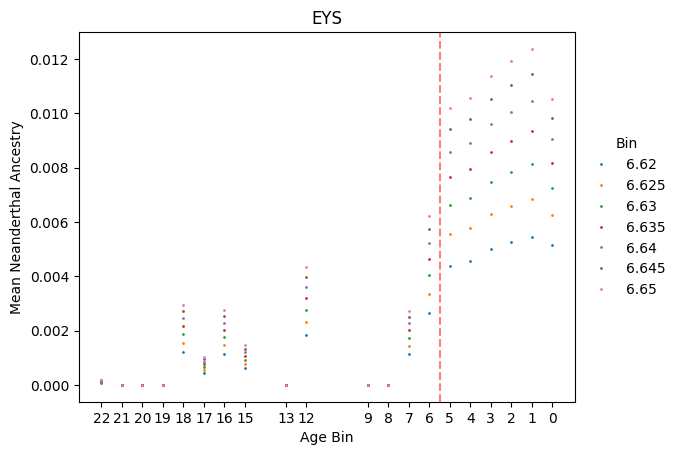

CHROMOSOME 7


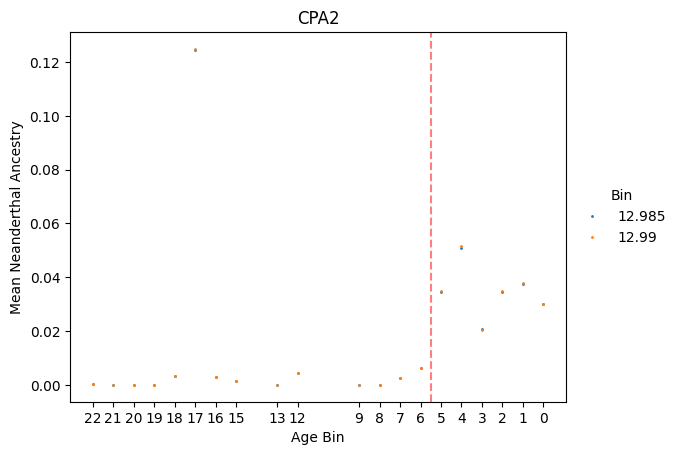

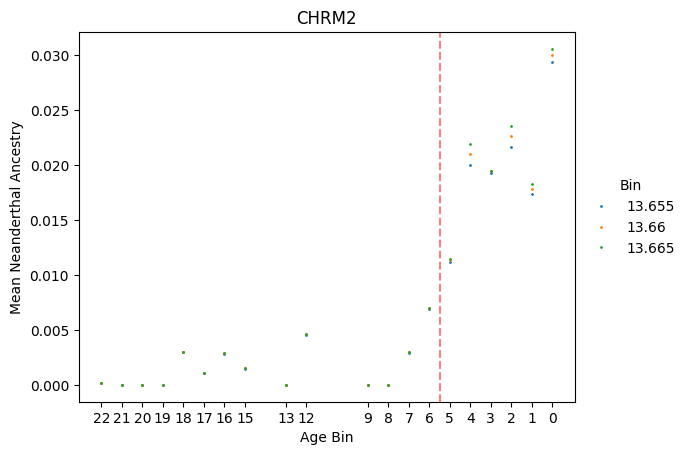

CHROMOSOME 8


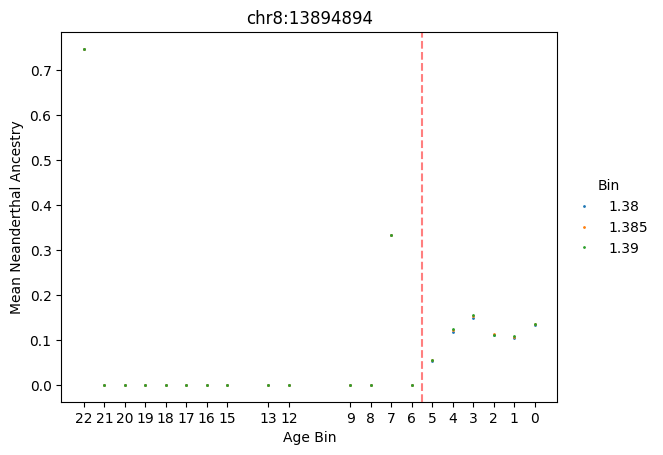

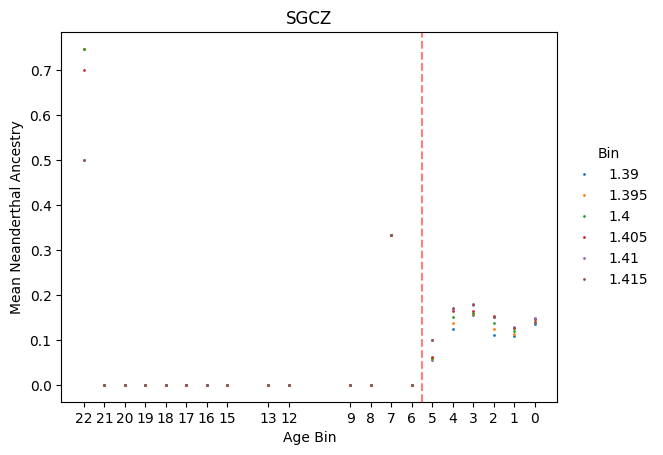

CHROMOSOME 9


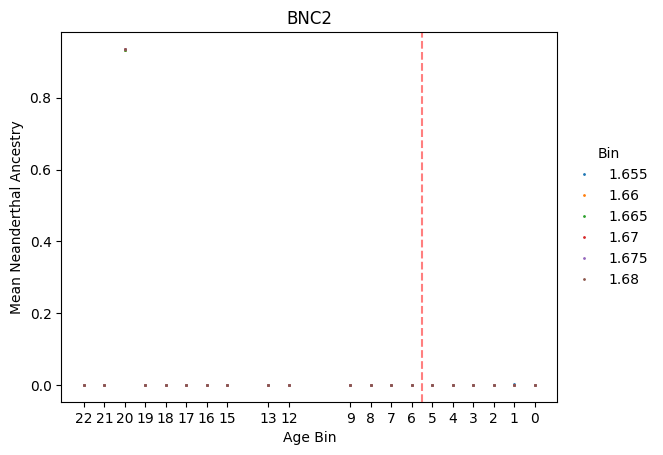

CHROMOSOME 11


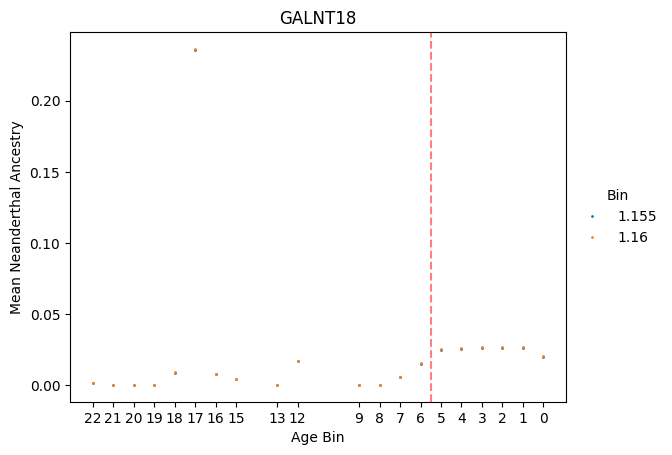

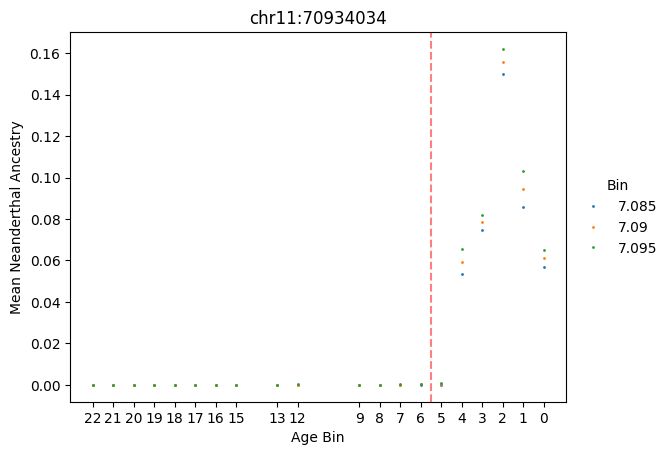

CHROMOSOME 12


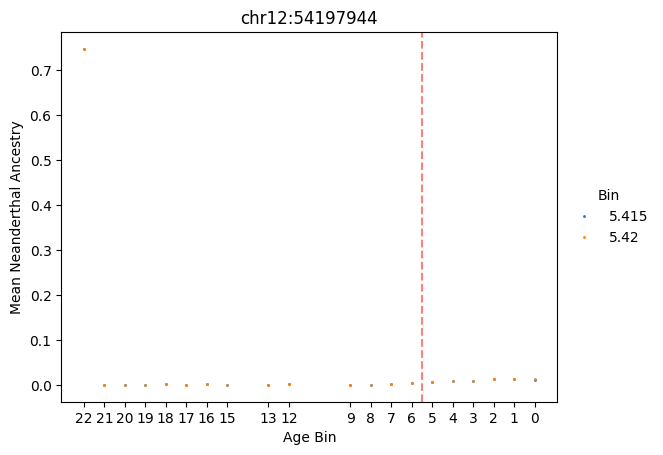

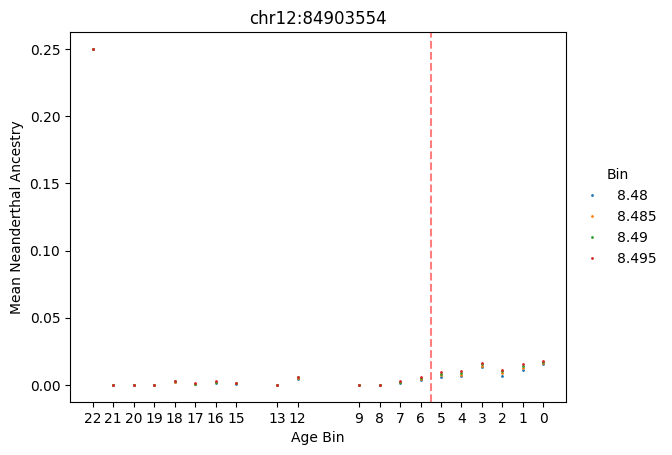

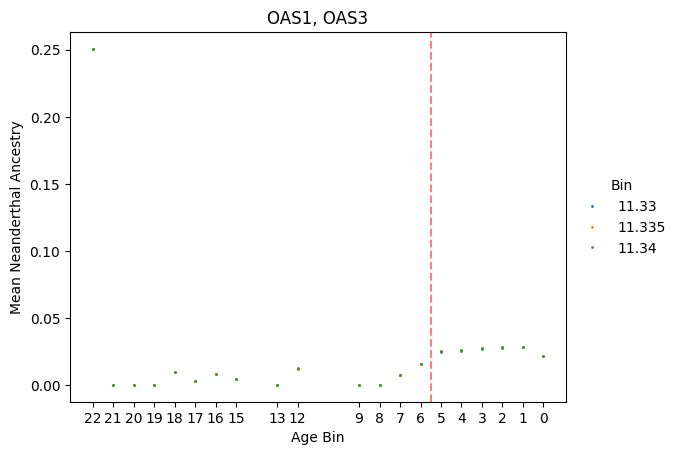

CHROMOSOME 14


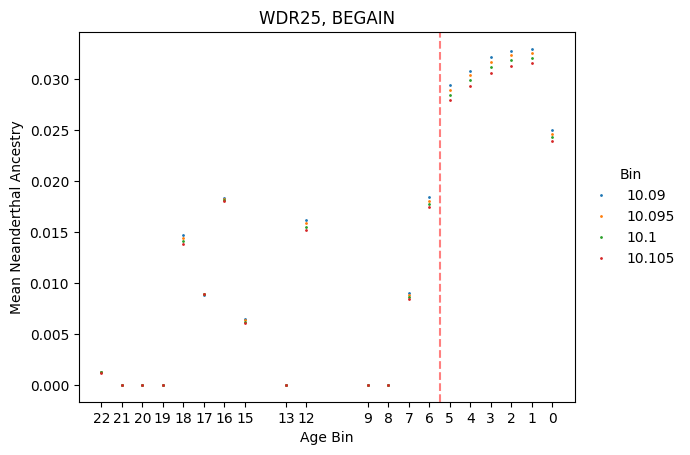

CHROMOSOME 15


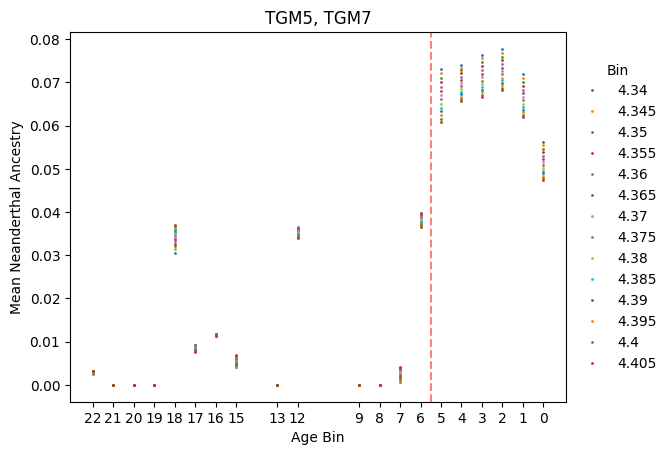

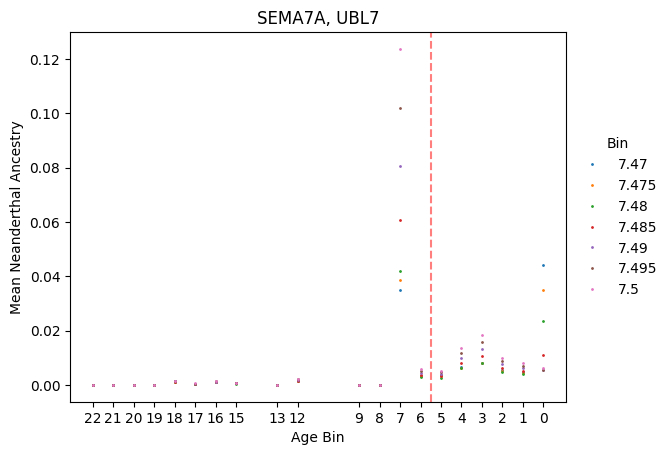

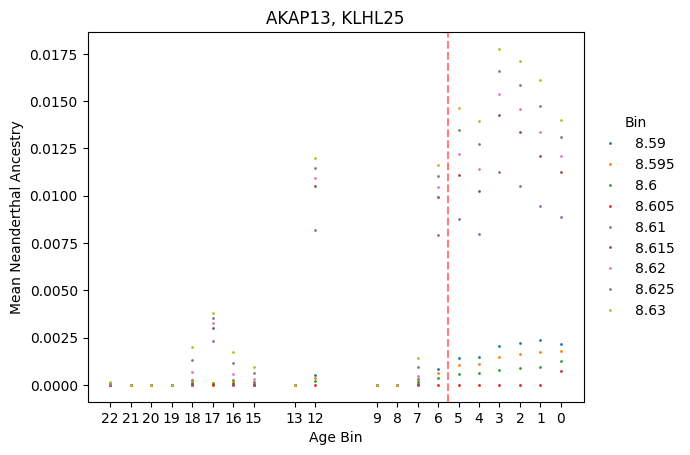

CHROMOSOME 16


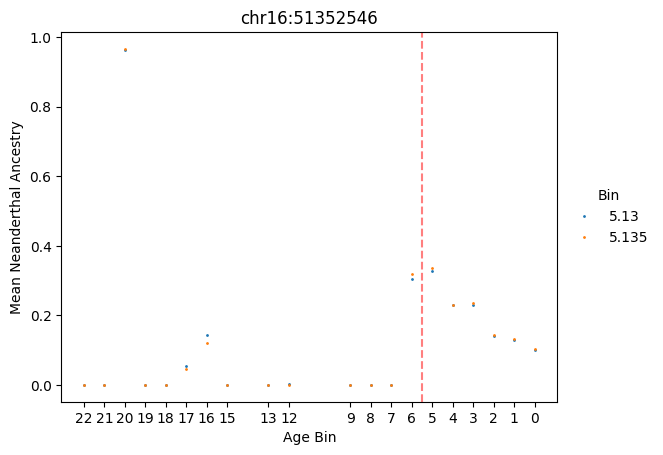

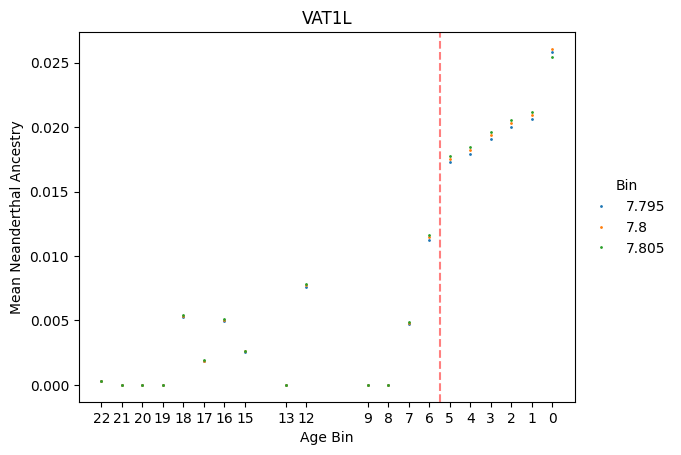

CHROMOSOME 18


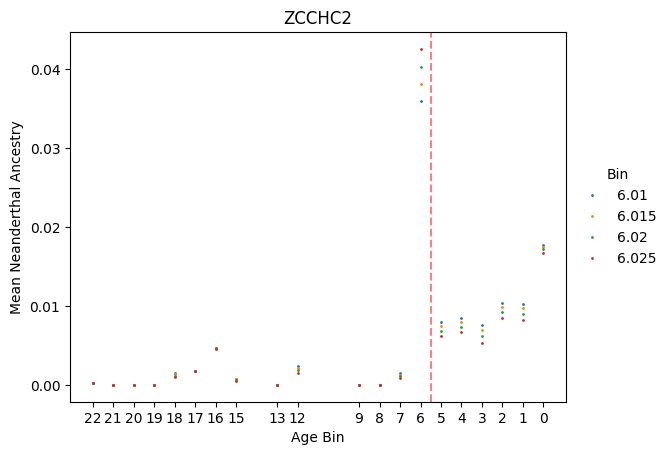

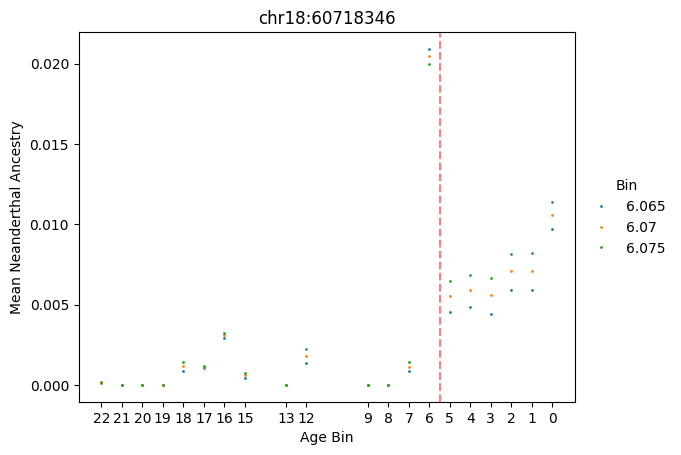

CHROMOSOME 19


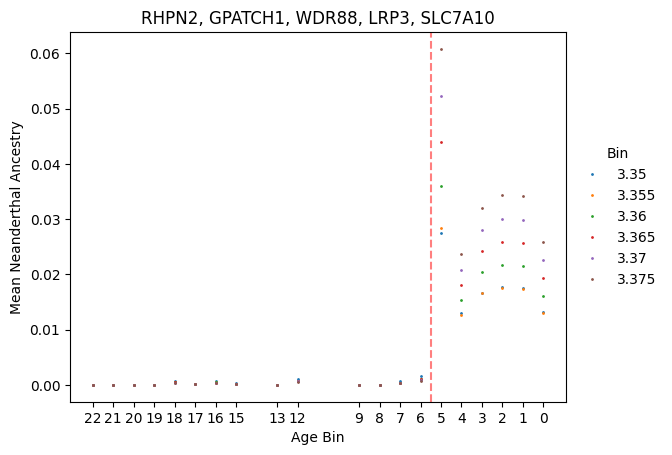

CHROMOSOME 20


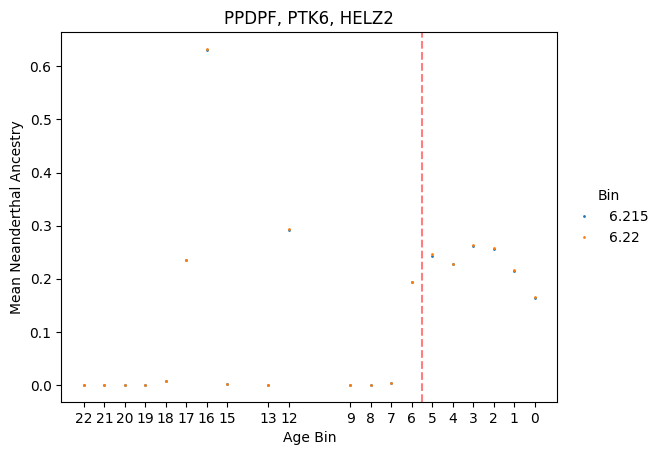

CHROMOSOME 22


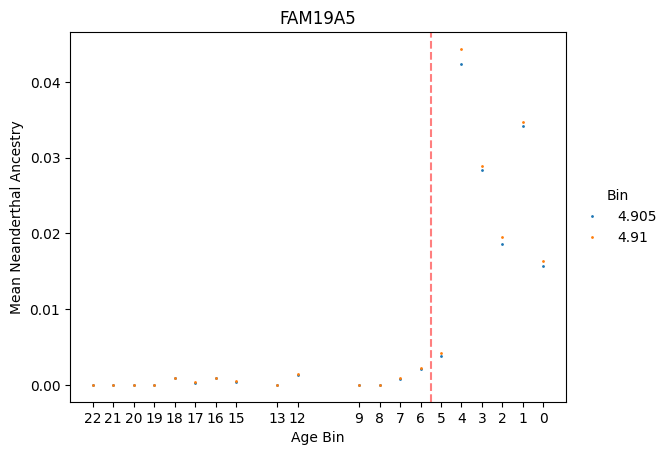

In [46]:
for i in regions["chrom"].unique():
    print(f"CHROMOSOME {i}")
    plot_rois(i)

In [27]:
# binned.iloc[:, roi_bidx].plot(style="o", markersize=1, )

<Axes: >

3

## Make boxplots instead

In [22]:
regions.iloc[2]

chrom                      1
start              201038832
stop               201102553
genes         CACNA1S, ASCL5
plot label     CACNA1S,ASCL5
Name: 2, dtype: object

In [19]:
metadata.head(1)

,Latitude,Longitude,Data source,Age average,Sex,Bin
Individual ID,,,,,,
baa01,-29.54,31.22,Schlebusch_Science_2017,1909.0,male,1.0


In [18]:
# First pass of making separate bin for modern samples
# Just floor divide by bin width and add 1, unless it's a modern sample in which case put it into bin 0
metadata["Bin"] = metadata["Age average"].apply(lambda x: x // bin_width + 1 if x != 0 else 0)
# metadata#.sort_values(by="Age average")


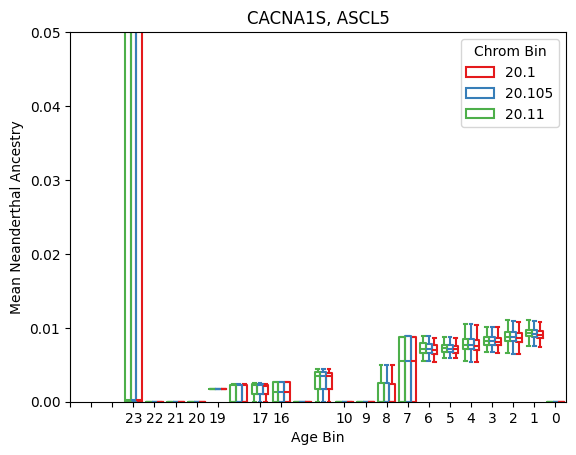

In [84]:
bin_width = 2000
metadata_temp = metadata.copy()
# Create age bins 
# TODO: Bins increase after 10kBP
metadata_temp["Age Bin"] = metadata_temp["Age average"].apply(lambda x: int(x // bin_width + 1) if x != 0 else 0)
unique_bins = sorted(metadata_temp["Age Bin"].unique().tolist())[::-1]
# TODO: Make this a for loop
row = regions.iloc[2]
# Find the chromosome bins associated with a given gene
start, end = row['start'], row['stop']
get_bidx = lambda x: x / 1e6 // .05
binmin, binmax = get_bidx(start), get_bidx(end)
roi_bidx = np.arange(binmin, binmax + 1)
# Transfer these introgression proportions to the metadata_temp
gene_ancestry = samplebybin.iloc[:, roi_bidx]
gene_bins_cM = gene_ancestry.columns
metadata_temp.loc[samplebybin.index, gene_bins_cM] = gene_ancestry.values
# Melt the df in order to plot
df = metadata_temp.reset_index().melt(
    id_vars=[i for i in metadata_temp.columns if i not in gene_bins_cM],
    value_vars=gene_bins_cM, 
    var_name="Chrom Bin"
    )
# Create boxplots at each age bin for each chrom bin
fig, ax = plt.subplots()
sns.boxplot(
    df,
    x="Age Bin", y="value", hue="Chrom Bin",
    ax=ax, palette="Set1", showfliers=False,
    fill=False
)
ax.invert_xaxis()
ax.set_ylabel("Mean Neanderthal Ancestry")
ax.set_xlabel("Age Bin")
ax.set_title(row["genes"] if not pd.isna(row['genes']) else row['plot label'])
ax.set_xticks(unique_bins)
# TODO: DELETE THIS IN ACTUAL FUNCTION!!!
ax.set_ylim(0, 0.05)
plt.show()


In [86]:
# df[df["Age Bin"] == 0]['value'].value_counts()
modern_samples = metadata[metadata["Age average"] == 0].index
samplebybin.loc[modern_samples].iloc[:, roi_bidx].describe()

,20.1,20.105,20.11
count,275.000000,275.000000,275.000000
mean,0.058181,0.054818,0.051665
std,0.234512,0.221234,0.209357
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,0.995485,0.991511


In [105]:
row

chrom                9
start         16596898
stop          16845056
genes             BNC2
plot label        BNC2
Name: 19, dtype: object

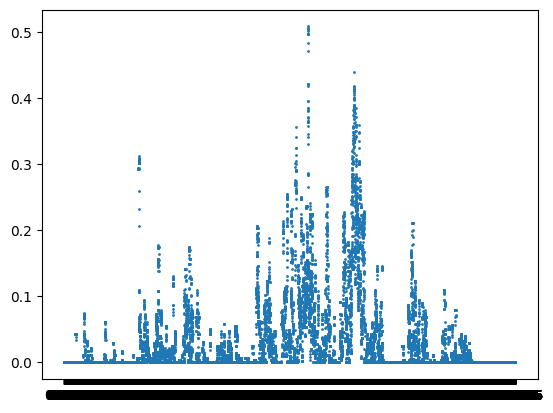

In [104]:
l = sample_by_bin.loc[modern_samples].mean()
plt.scatter(l.keys(), l.values, s=1)

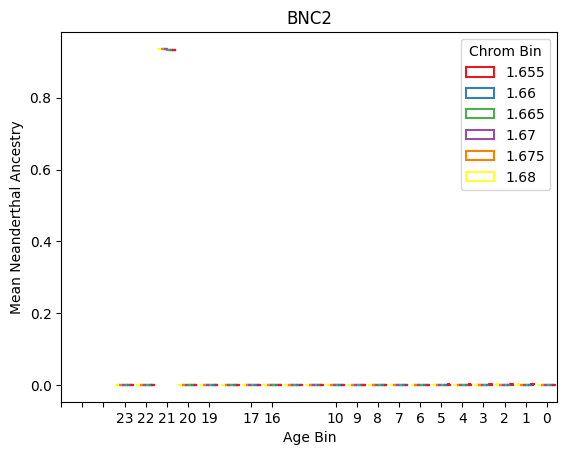

In [90]:
# def cplotv2(chrom):
chrom = 9
sample_by_bin = pd.read_csv(f"../processed-data/sample_by_bin/chr{chrom}.csv.gz", index_col=0)
# Need to manually rename modern samples :(
sample_by_bin.index = sample_by_bin.index.str.replace('.', '-')
bin_width = 2000
metadata_temp = metadata.copy()
# Create age bins 
# TODO: Bins increase after 10kBP
metadata_temp["Age Bin"] = metadata_temp["Age average"].apply(lambda x: int(x // bin_width + 1) if x != 0 else 0)
unique_bins = sorted(metadata_temp["Age Bin"].unique().tolist())[::-1]
# TODO: Make this a for loop
for _, row in regions[regions["chrom"] == chrom].iterrows():
    # Find the chromosome bins associated with a given gene
    start, end = row['start'], row['stop']
    get_bidx = lambda x: x / 1e6 // .05
    binmin, binmax = get_bidx(start), get_bidx(end)
    roi_bidx = np.arange(binmin, binmax + 1)
    # Transfer these introgression proportions to the metadata_temp
    gene_ancestry = sample_by_bin.iloc[:, roi_bidx]
    gene_bins_cM = gene_ancestry.columns
    metadata_temp.loc[sample_by_bin.index, gene_bins_cM] = gene_ancestry.values
    # Melt the df in order to plot
    df = metadata_temp.reset_index().melt(
        id_vars=[i for i in metadata_temp.columns if i not in gene_bins_cM],
        value_vars=gene_bins_cM, 
        var_name="Chrom Bin"
        )
    # Create boxplots at each age bin for each chrom bin
    fig, ax = plt.subplots()
    sns.boxplot(
        df,
        x="Age Bin", y="value", hue="Chrom Bin",
        ax=ax, palette="Set1", showfliers=False,
        fill=False
    )
    ax.invert_xaxis()
    ax.set_ylabel("Mean Neanderthal Ancestry")
    ax.set_xlabel("Age Bin")
    ax.set_title(row["genes"] if not pd.isna(row['genes']) else row['plot label'])
    ax.set_xticks(unique_bins)
    # TODO: DELETE THIS IN ACTUAL FUNCTION!!!
    # ax.set_ylim(0, 0.05)
    plt.show()
# cplotv2(9)

In [97]:
sample_by_bin[gene_bins_cM].describe()

,1.655,1.66,1.665,1.67,1.675,1.68
count,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000
mean,0.001525,0.001134,0.000598,0.000516,0.001034,0.001409
std,0.021904,0.021924,0.021948,0.021964,0.022061,0.022369
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001007,0.000614,0.000081,0.000000,0.000447,0.000759
50%,0.001191,0.000728,0.000097,0.000000,0.000545,0.000919
75%,0.001302,0.000797,0.000106,0.000000,0.000601,0.001014
max,0.932887,0.933488,0.934090,0.934693,0.935300,0.935909
